# ToyShapes Experiments

This notebook provides the code to reproduce the results of the paper for what concerns the experiments on the ToyShapes data.


## 0. Preamble

In [1]:
import os

## if using Kaggle
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
  import sys
  sys.path.append('/kaggle/input')
  DIR = '/kaggle/input/'
else:
  DIR = ''

In [2]:
### Derandomization and determinism setup for reproducibibility
from toyshapes.utils import env_reproducibility, seed_all
env_reproducibility()

### Pytorch engine --- uses GPU (cuda) if available
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Setting up the tasks to (re)run**
- if `RETRAIN` is True, all models (30 per group) will be retrained from scratch and saved locally, otherwise the checkpoints provided in the repo will be used
- if `REEVALUATE` is True, all models (30 per group) will be re-evaluated on the test set and the results saved locally, otherwise the results provided in the repo will be used
- NB: when set to True the model and results files provided in the repo, if present in the file system locally, will be overwritten

In [3]:
RETRAIN = False
REEVALUATE = False

## 1. ToyShapes Data

The ToyShapes data comprise synthetic images that contain geometric shapes over a square grid. We provide the data generating function and set it up with the parameters used for the paper. It also provides a table with a binary target variable taking value 1 if at least one `target_shape` is in the image.

The parameters are the following:

- `N`: dataset size, to be split into training and validation sets (paper: 1000)
- `val_size`: validation set split in [0,1] (paper: 0.2)
- `n_blocks`: a square integer defining the grid (paper: 16)
- `dim_per_block`: dimension per block of the grid (paper: 20 — implying 16x20*20=6400 pixels per image)
- `shapes`: the shapes to draw (paper: ['triangle', 'square', 'circle', 'void'])
- `target_shape`: the target shape considered for binary classification (paper: 'triangle')
- `rel_freq`: the inverse relative frequency of the `target_shape` (paper: 5 i.e. other shapes have 5 times more chance to be drawn)
- `backgrounds`: if True, the gray shade of the backgrounds varies image-wise (paper: True)
- `nonconvex`: probability in [0,1] to draw a nonconvex shape, i.e. the center of the shape is removed (paper: 0.25)

The parameters are stored in the data config file (`toyshapes/data.json`) 

In [4]:
import json

with open(DIR+'toyshapes/data.json', 'r') as f:
  DATA_KWARGS = json.load(f)
  
DATA_KWARGS

{'N': 1000,
 'val_size': 0.2,
 'n_blocks': 16,
 'dim_per_block': 20,
 'shapes': ['triangle', 'square', 'circle', 'void'],
 'target_shape': 'triangle',
 'rel_freq': 5,
 'backgrounds': True,
 'nonconvex': 0.25}

In the experiments, the same parameters are used and a random seed controls the generation. For example, with the seed 2025 we obtain 

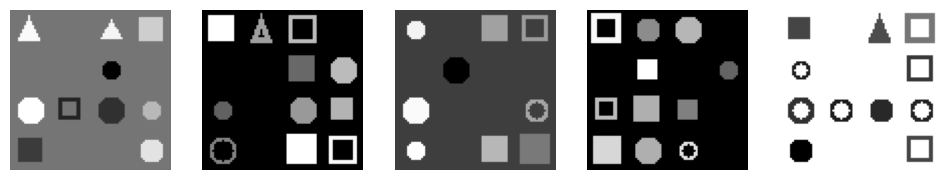

In [5]:
from toyshapes.data import make_dataset, generate_images
import matplotlib.pyplot as plt

seed_ = 2025
seed_all(seed_)

data = make_dataset(**DATA_KWARGS)
images, masks = generate_images(seed_, data, **DATA_KWARGS)

fig, axs = plt.subplots(1, 5, figsize=(12, 5))
for i in range(5):
  axs[i].imshow(images[i], cmap='gray')
  axs[i].axis('off')
plt.show()

## 2. Training the models

We set below some general training hyperparameters

In [6]:
SEED = 0                # initial random seed, incremented at each fit
VERBOSE = True          # whether to print training progress

TARGET_N_FITS = 30      # target number of successful fits 
MIN_ACC = 0.98          # minimum accuracy to consider a fit successful

BATCH_SIZE = 32         # training batch size
N_EPOCHS = 50           # maximum number of training epochs
FREQ_EVAL_PER_EPOCH = 3 # frequency of validation per epoch









# MIN_ACC = 0.           # minimum accuracy to consider a fit successful
# TARGET_N_FITS = 5      # target number of successful fits 
# N_EPOCHS = 1           # maximum number of training epochs

### 2.1. Baseline CNNs

The hyperparameters for the CNNs, on which GradCAMs are then calculated, are set below:

In [7]:
CNN_KWARGS = {
  ## architecture
  'Cbase': 32,            # number of output channels of the first convolutional layer
  'depth': 3,             # number of convolutional layers
  'skip': True,           # whether to use skip connections

  ## optimization
  'lr': 1e-3,             # learning rate
  'betas': (0.9, 0.999),  # Adam optimizer betas

  ## regularization
  'dropout': 0.1,         # dropout rate
}

path = "toyshapes/cnns/"

**Training CNNs**

In [8]:
from torch.utils.data import DataLoader, TensorDataset
from toyshapes.utils import create_dir, model_size
from toyshapes.train import training_loop, SDLoss
from toyshapes.data import split_data
from toyshapes.models import CNN

In [9]:
if RETRAIN:

  ## Create directory to save results and save CNN hyperparameters
  create_dir(path, empty=True)
  with open(path + 'cfg.json', 'w') as f:
    json.dump(CNN_KWARGS, f, indent=2)

  ## Initialize number of successful fits and seed
  N_FITS = 0; seed_ = SEED
    
  ## Training loop
  while N_FITS < TARGET_N_FITS:

    if VERBOSE:
      print("*" * 20, "SEED", seed_, "*" * 20)

    ## Generate dataset for the current seed
    seed_all(seed_)
    data = make_dataset(**DATA_KWARGS)
    images, masks = generate_images(seed_, data, **DATA_KWARGS)
    
    ## Split into training and validation sets
    X_train, y_train, Pi_star_train, X_val, y_val, Pi_star_val = \
      split_data(images, masks, data.y.values, seed_, verbose=False, **DATA_KWARGS)
    train_loader = DataLoader(TensorDataset(X_train, y_train, Pi_star_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    ## Determine evaluation frequency for validation, verbose, and model saving
    FREQ_EVAL = max(1, len(train_loader) // FREQ_EVAL_PER_EPOCH)
    
    ## Instantiate model, loss function, and optimizer
    Loss = SDLoss(lam=0)   # binary cross entropy 
    cnn = CNN(**CNN_KWARGS).to(device)
    optim = torch.optim.Adam(cnn.parameters(), lr=CNN_KWARGS['lr'], betas=CNN_KWARGS['betas'])
    
    if VERBOSE:
      model_size(cnn)

    ## Train the model, it will return whether the fit was successful based on validation accuracy (>= MIN_ACC)
    success = training_loop(cnn, optim, train_loader, val_loader, Loss, N_EPOCHS, device, seed_, 
                            verbose=VERBOSE, path=path, freq_eval=FREQ_EVAL, min_acc=MIN_ACC, **CNN_KWARGS)
    
    ## Update number of successful fits and seed
    if success:
      N_FITS += 1
      message = "Success! Fit {}/{}".format(N_FITS, TARGET_N_FITS)
      if VERBOSE:
        print(message)    
    seed_ += 1

### 2.2. Default PiNets

In [10]:
xdim = DATA_KWARGS['n_blocks'] * DATA_KWARGS['dim_per_block']**2 # dimension of the images, 6400 for the paper

PINET_KWARGS = {
  ## architecture
  'Cbase': 16,                      # number of output channels of the first convolutional layer 
  'depth': 3,                       # depth of the PiNet encoder
  'activation': 'sigmoid',          # activation function out of the decoder, last step to producing pi
  'hardSL': True,                   # whether to use a hard second look (i.e. multiply pi by z)
  'skip': False,                    # whether to use skip connections
  'use_decoder': True,              # whether to use an adequate decoder (deconvolutional layers), otherwise decoder is a naive dense layer
  'zdim': xdim,                     # dimension of the images (i.e. card(X), as we set Z=X)

  ## optimization
  'lr': 5e-3,                       # learning rate
  'betas': (0.9, 0.95),             # Adam optimizer betas

  ## regularization
  'dropout': 0.0,                   # dropout rate
  'lam': 0.0,                       # parsimony regularization on pi (not used for the paper, useful when setting activation to Tanh instead of Sigmoid) 
  'alpha_stab': 0.0,                # recursive feedback

  ## strong supervision (use of ground-truth pi)
  'gamma': 0,                       # strong labels loss; weight relative to class labels loss
}

path = "toyshapes/pinets_defaults/"

In [11]:
from toyshapes.models import BinaryConvPiNet

In [12]:
if RETRAIN:

  ## Create directory to save results and save PiNets hyperparameters
  create_dir(path, empty=True)
  with open(path + 'cfg.json', 'w') as f:
    json.dump(PINET_KWARGS, f, indent=2)
  PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

  ## Initialize number of successful fits and seed
  N_FITS = 0; seed_ = SEED

  ## Training loop
  while N_FITS < TARGET_N_FITS:

    if VERBOSE:
      print("*" * 20, "SEED", seed_, "*" * 20)

    ## Generate dataset for the current seed
    seed_all(seed_)
    data = make_dataset(**DATA_KWARGS)
    images, masks = generate_images(seed_, data, **DATA_KWARGS)

    ## Split into training and validation sets
    X_train, y_train, Pi_star_train, X_val, y_val, Pi_star_val = \
      split_data(images, masks, data.y.values, seed_, verbose=True if seed_==0 else False, **DATA_KWARGS)
    train_loader = DataLoader(TensorDataset(X_train, y_train, Pi_star_train), batch_size=BATCH_SIZE, 
                              # if strong supervision, we do not shuffle, ensuring the same ground-truth examples are used in every epoch
                              shuffle=False if PINET_KWARGS['gamma']>0 else True) 
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    ## Determine evaluation frequency for validation, verbose, and model saving
    FREQ_EVAL = max(1, len(train_loader) // FREQ_EVAL_PER_EPOCH)
    
    ## Instantiate model, loss function, and optimizer
    Loss = SDLoss(**PINET_KWARGS)
    pinet = BinaryConvPiNet(**PINET_KWARGS).to(device)
    optim = torch.optim.Adam(pinet.parameters(), lr=PINET_KWARGS['lr'], betas=PINET_KWARGS['betas'])
    
    if VERBOSE:
      model_size(pinet)

    ## Train the model, it will return whether the fit was successful based on validation accuracy (>= MIN_ACC)
    success = training_loop(pinet, optim, train_loader, val_loader, Loss, N_EPOCHS, device, seed_, 
                            verbose=VERBOSE, path=path, freq_eval=FREQ_EVAL, min_acc=MIN_ACC, **PINET_KWARGS)
    
    ## Update number of successful fits and seed
    if success:
      N_FITS += 1
      message = "Success! Fit {}/{}".format(N_FITS, TARGET_N_FITS)
      if VERBOSE:
        print(message)    
    seed_ += 1

### 2.3. PiNets Naive Decoder

In [13]:
PINET_KWARGS['activation'] = 'sigmoid'
PINET_KWARGS['hardSL'] = True
PINET_KWARGS['use_decoder'] = False
PINET_KWARGS['alpha_stab'] = 0.0
PINET_KWARGS['gamma'] = 0.0

path = "toyshapes/pinets_naive/"

In [14]:
if RETRAIN:

  ## Create directory to save results and save PiNets hyperparameters
  create_dir(path, empty=True)
  with open(path + 'cfg.json', 'w') as f:
    json.dump(PINET_KWARGS, f, indent=2)
  PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

  ## Initialize number of successful fits and seed
  N_FITS = 0; seed_ = SEED

  ## Training loop
  while N_FITS < TARGET_N_FITS:

    if VERBOSE:
      print("*" * 20, "SEED", seed_, "*" * 20)

    ## Generate dataset for the current seed
    seed_all(seed_)
    data = make_dataset(**DATA_KWARGS)
    images, masks = generate_images(seed_, data, **DATA_KWARGS)

    ## Split into training and validation sets
    X_train, y_train, Pi_star_train, X_val, y_val, Pi_star_val = \
      split_data(images, masks, data.y.values, seed_, verbose=True if seed_==0 else False, **DATA_KWARGS)
    train_loader = DataLoader(TensorDataset(X_train, y_train, Pi_star_train), batch_size=BATCH_SIZE, 
                              # if strong supervision, we do not shuffle, ensuring the same ground-truth examples are used in every epoch
                              shuffle=False if PINET_KWARGS['gamma']>0 else True) 
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    ## Determine evaluation frequency for validation, verbose, and model saving
    FREQ_EVAL = max(1, len(train_loader) // FREQ_EVAL_PER_EPOCH)
    
    ## Instantiate model, loss function, and optimizer
    Loss = SDLoss(**PINET_KWARGS)
    pinet = BinaryConvPiNet(**PINET_KWARGS).to(device)
    optim = torch.optim.Adam(pinet.parameters(), lr=PINET_KWARGS['lr'], betas=PINET_KWARGS['betas'])
    
    if VERBOSE:
      model_size(pinet)

    ## Train the model, it will return whether the fit was successful based on validation accuracy (>= MIN_ACC)
    success = training_loop(pinet, optim, train_loader, val_loader, Loss, N_EPOCHS, device, seed_, 
                            verbose=VERBOSE, path=path, freq_eval=FREQ_EVAL, min_acc=MIN_ACC, **PINET_KWARGS)
    
    ## Update number of successful fits and seed
    if success:
      N_FITS += 1
      message = "Success! Fit {}/{}".format(N_FITS, TARGET_N_FITS)
      if VERBOSE:
        print(message)    
    seed_ += 1

### 2.4. PiNets Soft Second Look

In [15]:
PINET_KWARGS['activation'] = 'sigmoid'
PINET_KWARGS['hardSL'] = False
PINET_KWARGS['use_decoder'] = True
PINET_KWARGS['alpha_stab'] = 0.0
PINET_KWARGS['gamma'] = 0.0

path = "toyshapes/pinets_soft/"

In [16]:
if RETRAIN:

  ## Create directory to save results and save PiNets hyperparameters
  create_dir(path, empty=True)
  with open(path + 'cfg.json', 'w') as f:
    json.dump(PINET_KWARGS, f, indent=2)
  PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

  ## Initialize number of successful fits and seed
  N_FITS = 0; seed_ = SEED

  ## Training loop
  while N_FITS < TARGET_N_FITS:

    if VERBOSE:
      print("*" * 20, "SEED", seed_, "*" * 20)

    ## Generate dataset for the current seed
    seed_all(seed_)
    data = make_dataset(**DATA_KWARGS)
    images, masks = generate_images(seed_, data, **DATA_KWARGS)

    ## Split into training and validation sets
    X_train, y_train, Pi_star_train, X_val, y_val, Pi_star_val = \
      split_data(images, masks, data.y.values, seed_, verbose=True if seed_==0 else False, **DATA_KWARGS)
    train_loader = DataLoader(TensorDataset(X_train, y_train, Pi_star_train), batch_size=BATCH_SIZE, 
                              # if strong supervision, we do not shuffle, ensuring the same ground-truth examples are used in every epoch
                              shuffle=False if PINET_KWARGS['gamma']>0 else True) 
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    ## Determine evaluation frequency for validation, verbose, and model saving
    FREQ_EVAL = max(1, len(train_loader) // FREQ_EVAL_PER_EPOCH)
    
    ## Instantiate model, loss function, and optimizer
    Loss = SDLoss(**PINET_KWARGS)
    pinet = BinaryConvPiNet(**PINET_KWARGS).to(device)
    optim = torch.optim.Adam(pinet.parameters(), lr=PINET_KWARGS['lr'], betas=PINET_KWARGS['betas'])
    
    if VERBOSE:
      model_size(pinet)

    ## Train the model, it will return whether the fit was successful based on validation accuracy (>= MIN_ACC)
    success = training_loop(pinet, optim, train_loader, val_loader, Loss, N_EPOCHS, device, seed_, 
                            verbose=VERBOSE, path=path, freq_eval=FREQ_EVAL, min_acc=MIN_ACC, **PINET_KWARGS)
    
    ## Update number of successful fits and seed
    if success:
      N_FITS += 1
      message = "Success! Fit {}/{}".format(N_FITS, TARGET_N_FITS)
      if VERBOSE:
        print(message)    
    seed_ += 1

### 2.5. PiNets Feedback

In [17]:
PINET_KWARGS['activation'] = 'sigmoid'
PINET_KWARGS['hardSL'] = True
PINET_KWARGS['use_decoder'] = True
PINET_KWARGS['alpha_stab'] = 1000
PINET_KWARGS['gamma'] = 0.0

path = "toyshapes/pinets_feedback/"

In [18]:
if RETRAIN:

  ## Create directory to save results and save PiNets hyperparameters
  create_dir(path, empty=True)
  with open(path + 'cfg.json', 'w') as f:
    json.dump(PINET_KWARGS, f, indent=2)
  PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

  ## Initialize number of successful fits and seed
  N_FITS = 0; seed_ = SEED

  ## Training loop
  while N_FITS < TARGET_N_FITS:

    if VERBOSE:
      print("*" * 20, "SEED", seed_, "*" * 20)

    ## Generate dataset for the current seed
    seed_all(seed_)
    data = make_dataset(**DATA_KWARGS)
    images, masks = generate_images(seed_, data, **DATA_KWARGS)

    ## Split into training and validation sets
    X_train, y_train, Pi_star_train, X_val, y_val, Pi_star_val = \
      split_data(images, masks, data.y.values, seed_, verbose=True if seed_==0 else False, **DATA_KWARGS)
    train_loader = DataLoader(TensorDataset(X_train, y_train, Pi_star_train), batch_size=BATCH_SIZE, 
                              # if strong supervision, we do not shuffle, ensuring the same ground-truth examples are used in every epoch
                              shuffle=False if PINET_KWARGS['gamma']>0 else True) 
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    ## Determine evaluation frequency for validation, verbose, and model saving
    FREQ_EVAL = max(1, len(train_loader) // FREQ_EVAL_PER_EPOCH)
    
    ## Instantiate model, loss function, and optimizer
    Loss = SDLoss(**PINET_KWARGS)
    pinet = BinaryConvPiNet(**PINET_KWARGS).to(device)
    optim = torch.optim.Adam(pinet.parameters(), lr=PINET_KWARGS['lr'], betas=PINET_KWARGS['betas'])
    
    if VERBOSE:
      model_size(pinet)

    ## Train the model, it will return whether the fit was successful based on validation accuracy (>= MIN_ACC)
    success = training_loop(pinet, optim, train_loader, val_loader, Loss, N_EPOCHS, device, seed_, 
                            verbose=VERBOSE, path=path, freq_eval=FREQ_EVAL, min_acc=MIN_ACC, **PINET_KWARGS)
    
    ## Update number of successful fits and seed
    if success:
      N_FITS += 1
      message = "Success! Fit {}/{}".format(N_FITS, TARGET_N_FITS)
      if VERBOSE:
        print(message)    
    seed_ += 1

### 2.6. Ensembles of PiNets

In [19]:
PINET_KWARGS['activation'] = 'sigmoid'
PINET_KWARGS['hardSL'] = True
PINET_KWARGS['use_decoder'] = True
PINET_KWARGS['alpha_stab'] = 0.0
PINET_KWARGS['gamma'] = 0.0

path = "toyshapes/pinets_ensemble/"

In [20]:
SIZE_ENSEMBLE = 10      # number of models in the ensemble

In [21]:
if RETRAIN:

  ## Create directory to save results and save PiNets hyperparameters
  create_dir(path, empty=True)
  with open(path + 'cfg.json', 'w') as f:
    json.dump(PINET_KWARGS, f, indent=2)
  PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

  ## Initialize number of ensembles and ensemble seed
  N_ENSEMBLES = 0; SEED_ = 2025

  ## Ensemble loop
  while N_ENSEMBLES < TARGET_N_FITS:
    
    ## Create directory for the current ensemble
    path_ens = path + f'ensemble_{N_ENSEMBLES+1}/'
    create_dir(path_ens, empty=True)

    if VERBOSE:
      print("*" * 40, "ENSEMBLE SEED_", SEED_, "*" * 40)

    ## Generate dataset for the current seed
    seed_all(SEED_)
    data = make_dataset(**DATA_KWARGS)
    images, masks = generate_images(SEED_, data, **DATA_KWARGS)

    ## Split into training and validation sets
    X_train, y_train, Pi_star_train, X_val, y_val, Pi_star_val = \
      split_data(images, masks, data.y.values, SEED_, verbose=True, **DATA_KWARGS)

    ## Initialize number of fits for the current ensemble and seed
    N_FITS = 0; seed_ = 0

    ## Training loop
    while N_FITS < SIZE_ENSEMBLE:

      seed_all(seed_)
      if VERBOSE:
        print("*" * 20, "SEED", seed_, "*" * 20)
      
      ## Generate dataset for the current seed
      train_loader = DataLoader(TensorDataset(X_train, y_train, Pi_star_train), batch_size=BATCH_SIZE, shuffle=True)
      val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

      ## Determine evaluation frequency for validation, verbose, and model saving
      FREQ_EVAL = max(1, len(train_loader) // FREQ_EVAL_PER_EPOCH)
      
      ## Instantiate model, loss function, and optimizer
      Loss = SDLoss(**PINET_KWARGS)
      pinet = BinaryConvPiNet(**PINET_KWARGS).to(device)
      optim = torch.optim.Adam(pinet.parameters(), lr=PINET_KWARGS['lr'], betas=PINET_KWARGS['betas'])
      
      if VERBOSE:
        model_size(pinet)

      ## Train the model, it will return whether the fit was successful based on validation accuracy (>= MIN_ACC)
      success = training_loop(pinet, optim, train_loader, val_loader, Loss, N_EPOCHS, device, seed_, 
                              verbose=VERBOSE, path=path_ens, freq_eval=FREQ_EVAL, min_acc=MIN_ACC, **PINET_KWARGS)
      
      ## Update number of successful fits and seed
      if success:
        N_FITS += 1
        message = "Success! Fit {}/{}".format(N_FITS, SIZE_ENSEMBLE)
        if VERBOSE:
          print(message)    
      seed_ += 1

    ## Update number of ensembles and ensemble seed
    N_ENSEMBLES += 1; SEED_ += 1

### 2.7. Strongly-supervised PiNets

In [22]:
PINET_KWARGS['activation'] = 'sigmoid'
PINET_KWARGS['hardSL'] = True
PINET_KWARGS['use_decoder'] = True
PINET_KWARGS['alpha_stab'] = 0.0
PINET_KWARGS['gamma'] = 1000

path = "toyshapes/pinets_strong/"

In [23]:
if RETRAIN:

  ## Create directory to save results and save PiNets hyperparameters
  create_dir(path, empty=True)
  with open(path + 'cfg.json', 'w') as f:
    json.dump(PINET_KWARGS, f, indent=2)
  PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

  ## Initialize number of successful fits and seed
  N_FITS = 0; seed_ = SEED

  ## Training loop
  while N_FITS < TARGET_N_FITS:

    if VERBOSE:
      print("*" * 20, "SEED", seed_, "*" * 20)

    ## Generate dataset for the current seed
    seed_all(seed_)
    data = make_dataset(**DATA_KWARGS)
    images, masks = generate_images(seed_, data, **DATA_KWARGS)

    ## Split into training and validation sets
    X_train, y_train, Pi_star_train, X_val, y_val, Pi_star_val = \
      split_data(images, masks, data.y.values, seed_, verbose=True if seed_==0 else False, **DATA_KWARGS)
    train_loader = DataLoader(TensorDataset(X_train, y_train, Pi_star_train), batch_size=BATCH_SIZE, 
                              # if strong supervision, we do not shuffle, ensuring the same ground-truth examples are used in every epoch
                              shuffle=False if PINET_KWARGS['gamma']>0 else True) 
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    ## Determine evaluation frequency for validation, verbose, and model saving
    FREQ_EVAL = max(1, len(train_loader) // FREQ_EVAL_PER_EPOCH)
    
    ## Instantiate model, loss function, and optimizer
    Loss = SDLoss(**PINET_KWARGS)
    pinet = BinaryConvPiNet(**PINET_KWARGS).to(device)
    optim = torch.optim.Adam(pinet.parameters(), lr=PINET_KWARGS['lr'], betas=PINET_KWARGS['betas'])
    
    if VERBOSE:
      model_size(pinet)

    ## Train the model, it will return whether the fit was successful based on validation accuracy (>= MIN_ACC)
    success = training_loop(pinet, optim, train_loader, val_loader, Loss, N_EPOCHS, device, seed_, 
                            verbose=VERBOSE, path=path, freq_eval=FREQ_EVAL, min_acc=MIN_ACC, **PINET_KWARGS)
    
    ## Update number of successful fits and seed
    if success:
      N_FITS += 1
      message = "Success! Fit {}/{}".format(N_FITS, TARGET_N_FITS)
      if VERBOSE:
        print(message)    
    seed_ += 1

## 3. Evaluation on Test set

In [24]:
## set seed
SEED = 314 * 1618

## set size for test set
DATA_KWARGS['N'] = 1000




DATA_KWARGS['N'] = 50

In [25]:
seed_all(SEED)
data = make_dataset(**DATA_KWARGS)
images, masks = generate_images(SEED, data, **DATA_KWARGS)

X_test = torch.tensor(images, dtype=torch.float32)
y_test = torch.tensor((data.y > 0) * 1, dtype=torch.float32)
Pi_star_test = torch.tensor(masks, dtype=torch.float32)

In [26]:
import numpy as np

## define thresholds for the 'optimal' detection approach
thresholds = np.logspace(-4, 0, 100) 

### 3.1. Evaluate GradCAMs (on CNNs)

In [27]:
from glob import glob
from toyshapes.eval import evaluate_cnns
Groups = {}

In [28]:
if REEVALUATE:

  saved_models = glob(DIR+'toyshapes/cnns/*.pth')
  saved_models.sort()
  CNN_KWARGS = json.load(open(os.path.join(DIR+'toyshapes/cnns/cfg.json'), 'r'))

  results = evaluate_cnns(thresholds, saved_models, CNN_KWARGS, X_test, y_test, Pi_star_test, device)
  Groups['cnn_gradcam'] = results['CAMs']

### 3.2. Evaluate PiNets

In [29]:
from toyshapes.eval import evaluate_pinets, evaluate_ensemble

In [30]:
if REEVALUATE:

  ## Locate all PiNet model folders
  model_folders = glob(DIR+"toyshapes/pinets*")

  for i, folder in enumerate(model_folders):

    if 'ensemble' in folder:
      continue
    print(f'[{i+1}/{len(model_folders)}] Evaluating {folder}')

    ## Locate all saved models in the folder
    saved_models = glob(folder+'/*.pth')
    saved_models.sort()
    
    ## load PiNet hyperparameters
    PINET_KWARGS = json.load(open(os.path.join(folder, 'cfg.json'), 'r'))
    PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

    ## evaluate models in the folder
    Groups[folder.split('/')[-1]] = evaluate_pinets(thresholds, saved_models, PINET_KWARGS, X_test, y_test, Pi_star_test, device)

In [31]:
if REEVALUATE:
  
  ## Locate all PiNet ensemble folders
  ens_pools = glob(DIR+"toyshapes/pinets_ensemble/")

  for i, folder in enumerate(ens_pools):

    print(f'[{i+1}/{len(ens_pools)}] Evaluating {folder}')

    ## Load PiNet hyperparameters
    cfg_path = folder + '/cfg.json'
    PINET_KWARGS = json.load(open(os.path.join(cfg_path), 'r'))
    PINET_KWARGS['activation'] = nn.Sigmoid() if PINET_KWARGS['activation'] == 'sigmoid' else nn.Tanh() if PINET_KWARGS['activation'] == 'tanh' else nn.Identity()

    ## Locate all sub-folders corresponding to different ensembles
    sub_folders = glob(folder+'/ensemble*')
    sub_folders.sort()

    ## Evaluate each ensemble in the pool
    ensemble_results = []
    for j, ensemble in enumerate(sub_folders):
      print(' '*10 + f'[{j+1}/{len(sub_folders)}] Evaluating ensemble {ensemble.split("_")[-1]}')
      indiv_models = glob(ensemble+'/*.pth')
      indiv_models.sort()
      ensemble_results.append(evaluate_ensemble(thresholds, indiv_models, PINET_KWARGS, X_test, y_test, Pi_star_test, device))

    Groups['pinets_ensemble'] = ensemble_results

### Save

In [32]:
import pickle

if REEVALUATE:

  with open('toyshapes/results.pkl', 'wb') as f:
    pickle.dump(Groups, f)

## 4. Results Analysis

In [33]:
with open(DIR+'toyshapes/results.pkl', 'rb') as f:
  Groups = pickle.load(f)

order = [
  'cnn_gradcam',
  'pinets_naive',
  'pinets_soft',
  'pinets_defaults',
  'pinets_feedback',
  'pinets_ensemble',
  'pinets_strong',
]

Groups = {key.split('\\')[-1] if '\\' in key else key: value for key, value in Groups.items()}
Groups = {key: Groups[key] for key in order if key in Groups}
Groups.keys()

dict_keys(['cnn_gradcam', 'pinets_naive', 'pinets_soft', 'pinets_defaults', 'pinets_feedback', 'pinets_ensemble', 'pinets_strong'])

In [34]:
SAVE = False
if SAVE:
  os.makedirs('toyshapes/images', exist_ok=True)

colors = np.array([
 (0.224, 0.686, 0.816),
 (0.031, 0.231, 0.71),
 (0.251, 0.576, 0.29),
 (0.137, 0.847, 0.039),
 (0.918, 0.875, 0.161),
 (0.925, 0.561, 0.161),
 (0.988, 0.11, 0.157),
 (0.75, 0.110, 0.75)
])

# slightly darken by multiplying by a factor < 1
factor = 0.85
colors = np.clip(colors * factor, 0.0, 1.0)

In [35]:
from toyshapes.utils import make_legend_label, compute_ellipse_parameters, inner_false_indices
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.patches import Ellipse
import seaborn as sns

### 4.1. Meaningfulness

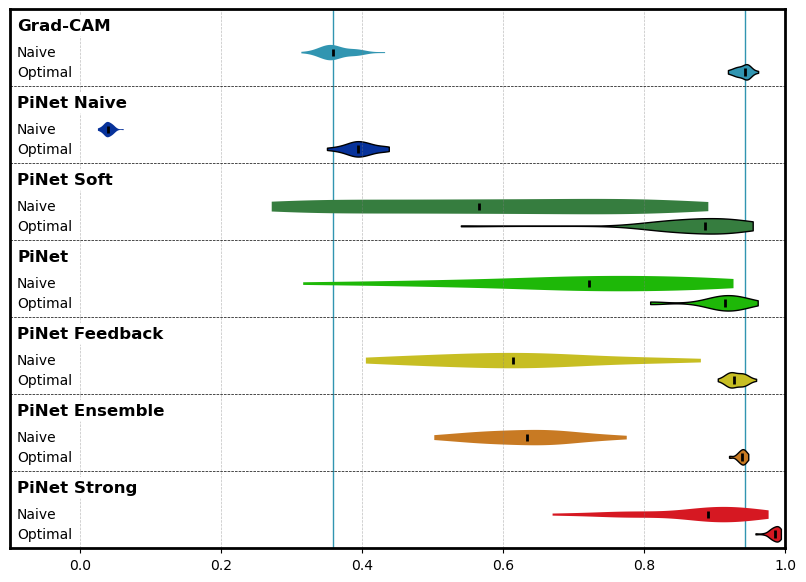

In [36]:
plt.figure(figsize=(10, 7), dpi=100)

min_ = 1.0
for i, (name, MODELS) in enumerate(Groups.items()):

  c = colors[i]
  plt.text(-.09, i*4, make_legend_label(name), fontsize=12, ha='left', va='bottom', fontweight='bold',
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))
  plt.text(-.09, i*4+1, 'Naive', fontsize=10, ha='left', va='center')
  plt.text(-.09, i*4+2, 'Optimal', fontsize=10, ha='left', va='center')
  
  naive = np.array([res['naive']['score'] for res in MODELS])
  v = plt.violinplot(naive, positions=[i*4+1], widths=0.8, vert=False, showmedians=True, showextrema=False)
  for b in v['bodies']:
    b.set_facecolor(c); b.set_alpha(1); b.set_linewidth(0)
  v['cmedians'].set_color('k'); v['cmedians'].set_linewidth(2)

  optimal = np.array([res['optimal']['score'] for res in MODELS])
  v = plt.violinplot(optimal, positions=[i*4+2], widths=0.8, vert=False, showmedians=True, showextrema=False)
  for b in v['bodies']:
    b.set_facecolor(c); b.set_edgecolor('k'); b.set_alpha(1)
  v['cmedians'].set_color('k'); v['cmedians'].set_linewidth(2)

  if i == 0:  
    baseline_median = np.median(naive)
    plt.axvline(baseline_median, color=c, linestyle='solid', linewidth=1, zorder=-1)
    baseline_optimal_median = np.median(optimal)
    plt.axvline(baseline_optimal_median, color=c, linestyle='solid', linewidth=1, zorder=-1)

  plt.axhline(i*4+3-.25, color='black', linestyle='--', linewidth=0.5)

plt.grid(axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.5, zorder=-2)

plt.gca().tick_params(axis='y', length=0)
plt.gca().set_yticks([])

for spine in plt.gca().spines.values():
  spine.set_linewidth(2)

plt.ylim(-1.25, i*4+3-.25)
plt.xlim(-.1, 1)
plt.gca().invert_yaxis()

if SAVE:
  plt.savefig('toyshapes/images/toyshapes_detection_perf_all.png', dpi=150, bbox_inches='tight')
  plt.savefig('toyshapes/images/toyshapes_detection_perf_all.svg', dpi=150, bbox_inches='tight')
  plt.savefig('toyshapes/images/toyshapes_detection_perf_all.pdf', dpi=150, bbox_inches='tight')
plt.show()

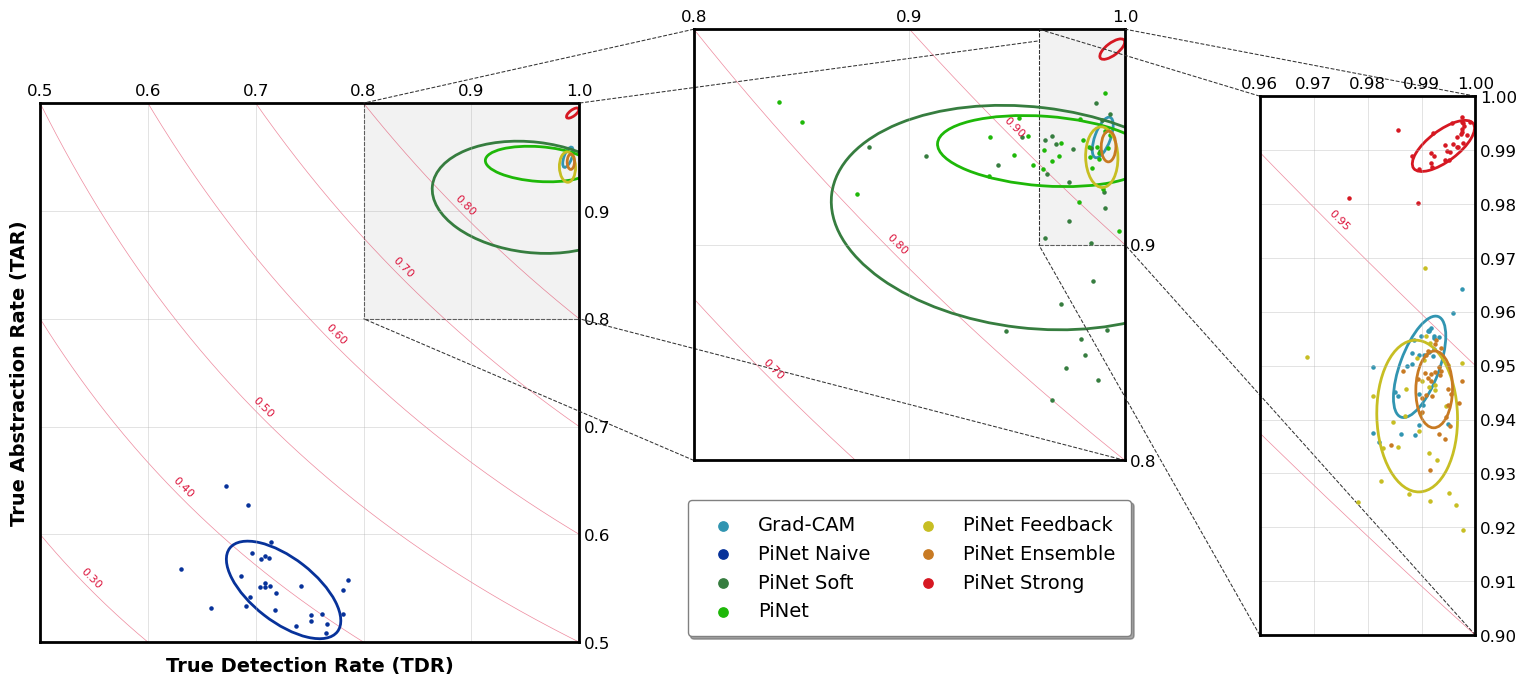

In [37]:
fig, ax_main = plt.subplots(figsize=(7, 7), dpi=100)

# ------------------------------------------------------
# Main plot
# ------------------------------------------------------

for i, (name, MODELS) in enumerate(Groups.items()):
    tdrs = np.array([res['optimal']['tdr'] for res in MODELS])
    tars = np.array([res['optimal']['tar'] for res in MODELS])
    if 'naive' in name:
        ax_main.scatter(tdrs, tars, s=5, color=colors[i], alpha=1)

    p_ = compute_ellipse_parameters(tdrs, tars)
    ell = Ellipse(xy=p_['mean'], width=p_['width'], height=p_['height'], angle=p_['angle'],
                    edgecolor=colors[i], facecolor='none', lw=2, alpha=1)
    ax_main.add_patch(ell)

x_vals_main = np.linspace(0.5, 1.0, 200)
for level in np.arange(0.3, 0.85, 0.1):
    ax_main.plot(x_vals_main, level / x_vals_main, c='crimson', lw=.5, alpha=.5, ls='solid', zorder=0)
    # midpoint of the curve y=a/x is at a=xy st. x=y => sqrt(a)
    point = level**.5 
    ax_main.annotate(f'{level:.2f}', xy=(point, point), xytext=(point, point), zorder=3,
                      fontsize=8, color='crimson', ha='center', va='bottom', rotation=-45)

ax_main.set_xticks(np.arange(0.5, 1.01, 0.1)); ax_main.set_yticks(np.arange(0.5, 1, 0.1))
ax_main.set_xlim(0.5, 1.0); ax_main.set_ylim(0.5, 1.0)

# ------------------------------------------------------
# First inset
# ------------------------------------------------------

ax_inset = zoomed_inset_axes(
    ax_main, zoom=2, loc='upper left',
    bbox_to_anchor=(1.2, 1.15), bbox_transform=ax_main.transAxes
)

for i, (name, MODELS) in enumerate(Groups.items()):
    if 'naive' in name:
        ax_inset.scatter([], [], s=5, color=colors[i], alpha=1, label=make_legend_label(name))
        continue
    tdrs = np.array([res['optimal']['tdr'] for res in MODELS])
    tars = np.array([res['optimal']['tar'] for res in MODELS])
    if 'soft' in name or 'defaults' in name:
        ax_inset.scatter(tdrs, tars, s=5, color=colors[i], alpha=1, label=make_legend_label(name))
    else:
        ax_inset.scatter([], [], s=5, color=colors[i], alpha=1, label=make_legend_label(name))

    p_ = compute_ellipse_parameters(tdrs, tars)
    ell = Ellipse(xy=p_['mean'], width=p_['width'], height=p_['height'], angle=p_['angle'],
                edgecolor=colors[i], facecolor='none', lw=2, alpha=1)
    ax_inset.add_patch(ell)

x_vals_inset = np.linspace(0.8, 1.0, 200)
for level in np.arange(0.7, 0.91, 0.1):
    ax_inset.plot(x_vals_inset, level / x_vals_inset, c='crimson', lw=.5, alpha=.5, ls='solid', zorder=0)
    # midpoint of the curve y=a/x is at a=xy st. x=y => sqrt(a)
    point = level**.5 
    ax_inset.annotate(f'{level:.2f}', xy=(point, point), xytext=(point, point), zorder=3,
                      fontsize=8, color='crimson', ha='center', va='bottom', rotation=-45)

ax_inset.set_xticks(np.arange(0.8, 1.01, 0.1)); ax_inset.set_yticks(np.arange(0.8, 1, 0.1))
ax_inset.set_xlim(0.8, 1.0); ax_inset.set_ylim(0.8, 1.0)

mark_inset(ax_main, ax_inset, loc1=1, loc2=3, fc="0.95", ec="0.2", linestyle='--', zorder=-1, lw=0.75)
mark_inset(ax_main, ax_inset, loc1=2, loc2=4, fc="none", ec="0.2", linestyle='--', zorder=-1, lw=0.75)

# ------------------------------------------------------
# Second inset
# ------------------------------------------------------

ax_inset2 = zoomed_inset_axes(
    ax_inset, zoom=2.5, loc='lower left',
    bbox_to_anchor=(2.25, 0), bbox_transform=ax_main.transAxes
)

for i, (name, MODELS) in enumerate(Groups.items()):
    if 'naive' in name or 'soft' in name or 'defaults' in name:
        continue
    tdrs = np.array([res['optimal']['tdr'] for res in MODELS])
    tars = np.array([res['optimal']['tar'] for res in MODELS])
    ax_inset2.scatter(tdrs, tars, s=5, color=colors[i], alpha=1)

    p_ = compute_ellipse_parameters(tdrs, tars)
    ell = Ellipse(xy=p_['mean'], width=p_['width'], height=p_['height'], angle=p_['angle'],
                edgecolor=colors[i], facecolor='none', lw=2, alpha=1)
    ax_inset2.add_patch(ell)

x_vals_inset = np.linspace(0.9, 1.0, 200)
for level in np.arange(0.7, 0.96, 0.05):
    ax_inset2.plot(x_vals_inset, level / x_vals_inset, c='crimson', lw=.5, alpha=.5, ls='solid', zorder=0)
    # midpoint of the curve y=a/x is at a=xy st. x=y => sqrt(a)
    point = level**.5 
    ax_inset2.annotate(f'{level:.2f}', xy=(point, point), xytext=(point, point), zorder=3,
                      fontsize=8, color='crimson', ha='center', va='bottom', rotation=-45)

ax_inset2.set_xticks(np.arange(0.9, 1.01, 0.01)); ax_inset2.set_yticks(np.arange(0.9, 1.01, 0.01))
ax_inset2.set_xlim(0.96, 1.0); ax_inset2.set_ylim(0.9, 1)

mark_inset(ax_inset, ax_inset2, loc1=1, loc2=3, fc="0.95", ec="0.2", linestyle='--', zorder=-1, lw=0.75)
mark_inset(ax_inset, ax_inset2, loc1=2, loc2=4, fc="none", ec="0.2", linestyle='--', zorder=-1, lw=0.75)

# ------------------------------------------------------
# General Appearance
# ------------------------------------------------------

for ax_ in [ax_main, ax_inset, ax_inset2]:
    # ax_.plot([0.5, 1.0], [0.5, 1.0], c='gray', lw=1, alpha=0.5, zorder=0)
    ax_.set_aspect('equal', adjustable='box')
    ax_.grid(True, which='both', linewidth=0.5, alpha=0.5)
    ax_.tick_params(axis='both', which='both', length=0, labelsize=12,
                    bottom=False, left=False, top=True, right=True, 
                    labelbottom=False, labelleft=False, labeltop=True, labelright=True)
    for spine in ax_.spines.values():
        spine.set_linewidth(2)

ax_main.set_xlabel('True Detection Rate (TDR)', fontsize=14, fontweight='bold', labelpad=10); 
ax_main.set_ylabel('True Abstraction Rate (TAR)', fontsize=14, fontweight='bold', labelpad=8)
ax_inset.legend(bbox_to_anchor=(.5, -0.25), loc='center', fontsize=14, markerscale=3, ncol=2,
                frameon=True, facecolor='white', edgecolor='gray', shadow=True, borderpad=0.8)

if SAVE:
    plt.savefig('toyshapes/images/toyshapes_detection_perf_optim.png', dpi=150, bbox_inches='tight')
    plt.savefig('toyshapes/images/toyshapes_detection_perf_optim.svg', dpi=150, bbox_inches='tight')
    plt.savefig('toyshapes/images/toyshapes_detection_perf_optim.pdf', dpi=150, bbox_inches='tight')
plt.show()

### 4.2. Ease of fine-tuning

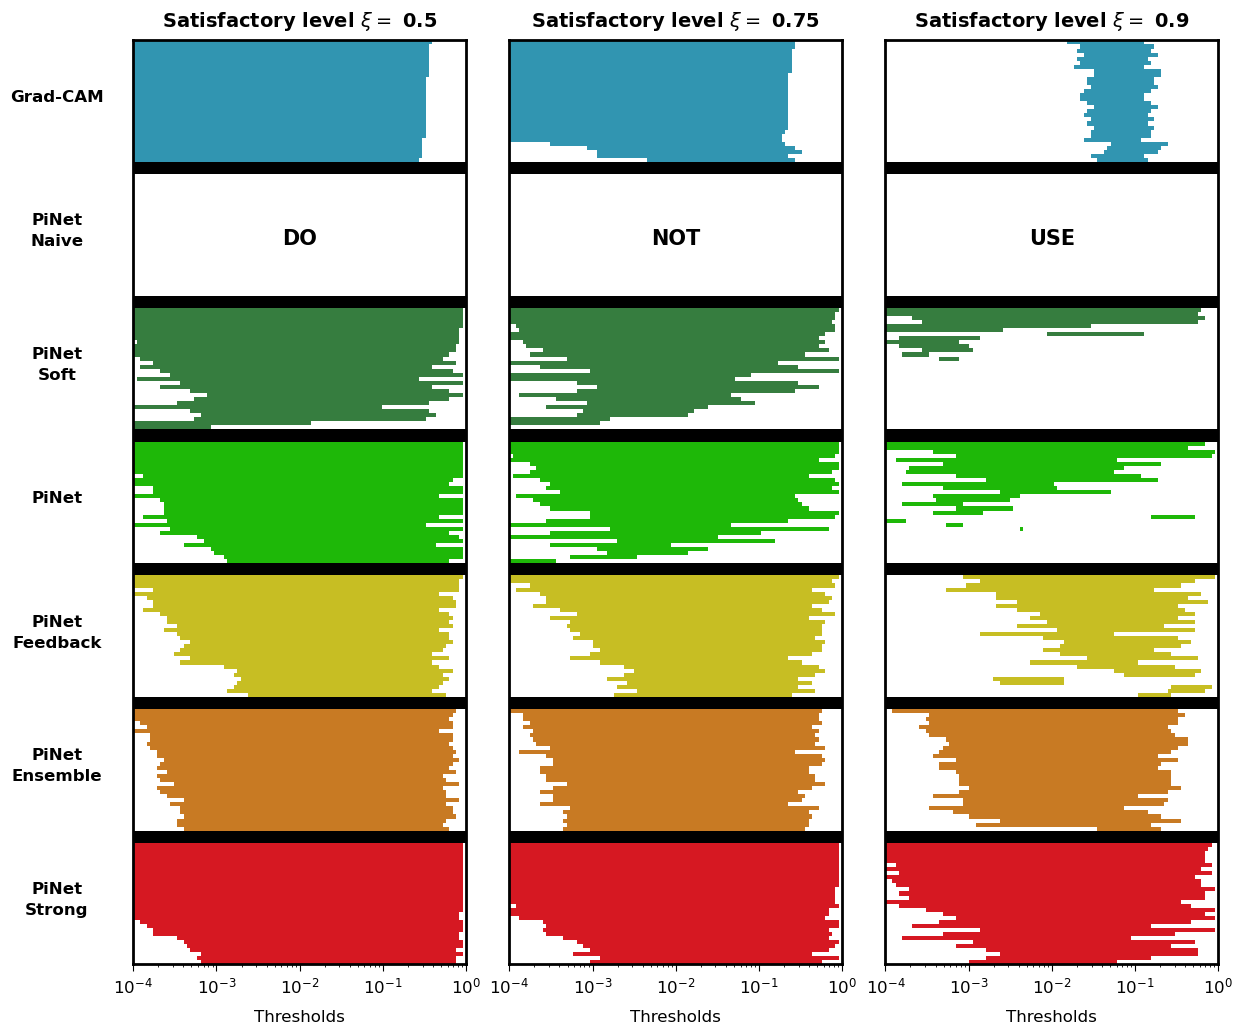

In [38]:
break_size = 3
satisfying_levels = [.5, .75, .9] 

pieces_of_humor = ['DO', 'NOT', 'USE']
fig, axes = plt.subplots(1, 3, figsize=(14, 12), dpi=100, sharey=True)
yticks = []

for idx, satisfying_level in enumerate(satisfying_levels):

  ax = axes[idx]; y_ = 0; old_y = 0
  for i, (name, MODELS) in enumerate(Groups.items()):

    thresholds_above = [thresholds[res['scores'] > satisfying_level] for res in MODELS]
    thresholds_below = [thresholds[res['scores'] <= satisfying_level] for res in MODELS]
    ranges = [-np.log10(t).max() - -np.log10(t).min() if len(t) > 0 else 0 for t in thresholds_above]

    for j in np.argsort(ranges):

      y_ += 1
      if len(thresholds_above[j]) > 0:
        ax.barh(y_, thresholds_above[j].max()-thresholds_above[j].min(), left=thresholds_above[j].min(),
          height=1, color=colors[i])
        
      inner_below_thresholds = inner_false_indices(MODELS[j]['scores'] > satisfying_level)
      if len(inner_below_thresholds) > 0:
        ax.scatter(thresholds[inner_below_thresholds], [y_]*len(inner_below_thresholds), color='white', s=10)

    for j in range(break_size):
      y_ += 1
      ax.barh(y_, 1-1e-4, height=1, color='k', left=1e-4)

    if 'naive' in name:
      ax.annotate(xy=(1e-2, (y_ + old_y) / 2), xycoords='data', text=pieces_of_humor[idx], 
                  fontsize=15, ha='center', va='center', fontweight='bold')

    if idx == 0:
        yticks.append((y_ + old_y) / 2 -2) 
    old_y = y_
  
  ax.tick_params(axis='y', which='both', length=0, pad=55)
  ax.tick_params(axis='x', labelsize=12, length=5)
  if idx > 0:
    ax.set_yticklabels([])

  ax.set_xlim(1e-4, 1); ax.set_ylim(.5, y_-break_size+.5)
  ax.set_xscale('log')
  ax.set_title(f"Satisfactory level $\\xi =$ {satisfying_level}", fontsize=14, fontweight='bold', pad=10)
  ax.set_xlabel("Thresholds", fontsize=12, labelpad=10)

  for spine in ax.spines.values():
    spine.set_linewidth(2)

labels = [make_legend_label(name).replace(' ', '\n') for name in Groups.keys()]
axes[0].set_yticks(yticks, labels, fontsize=12, fontweight='bold', va='center', ha='center', rotation=0, linespacing=1.5)
[ax.invert_yaxis() for ax in axes]

plt.subplots_adjust(wspace=0.13)

if SAVE:
  plt.savefig('toyshapes/images/toyshapes_detection_range.png', dpi=150, bbox_inches='tight')
  plt.savefig('toyshapes/images/toyshapes_detection_range.svg', dpi=150, bbox_inches='tight')
  plt.savefig('toyshapes/images/toyshapes_detection_range.pdf', dpi=150, bbox_inches='tight')
plt.show()

### 4.3. Recursive Accuracy Shift

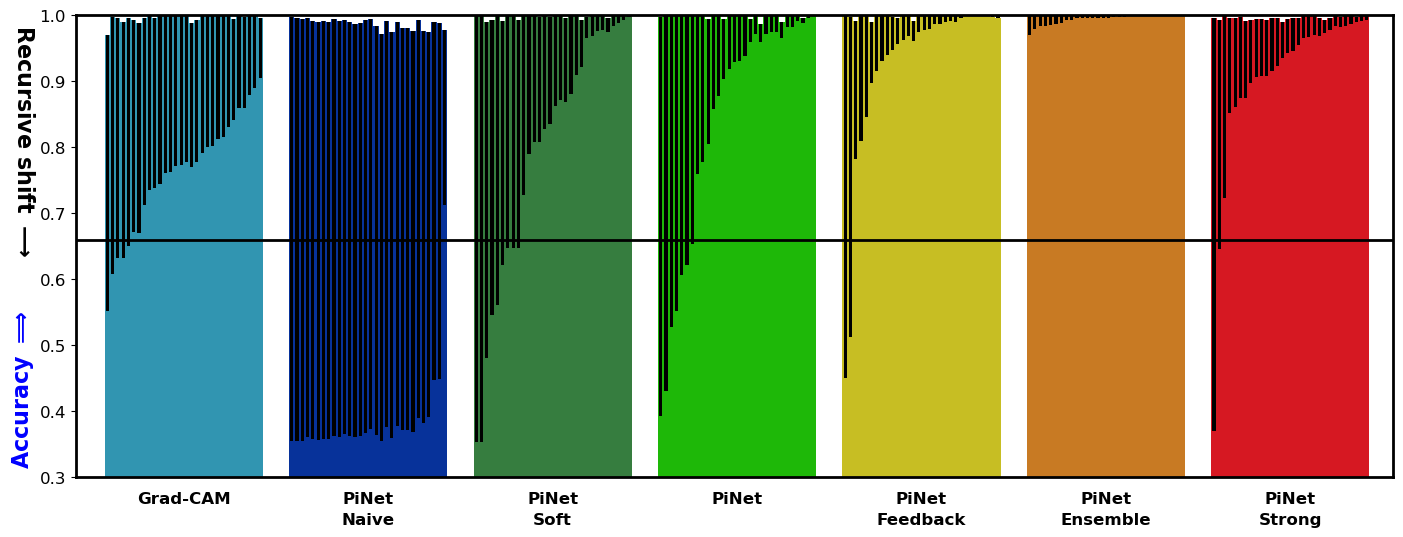

In [39]:
plt.figure(figsize=(17, 6), dpi=100)
break_size = 5

_accuracy_naive = max(y_test.mean(), 1-y_test.mean())
plt.axhline(_accuracy_naive, color='k', linewidth=2, zorder=2)

x_ = 0; old_x = 0; xticks = []
for i, (name, MODELS) in enumerate(Groups.items()):

  ACC = [res['acc'] for res in MODELS]
  SHIFT = [res['acc_shift'] for res in MODELS]

  for j in np.argsort(SHIFT)[::-1]:
    x_ += 1
    plt.bar(x_, ACC[j], width=1, color=colors[i])
    plt.bar(x_, SHIFT[j], bottom=ACC[j]-SHIFT[j], width=.6, color='k', alpha=1)

  for _ in range(break_size):
    x_ += 1

  xticks.append((x_ + old_x) / 2 - 2)
  old_x = x_

for spine in plt.gca().spines.values():
  spine.set_linewidth(2)

labels = [make_legend_label(name).replace('PiNet ', 'PiNet\n') for name in Groups.keys()]
plt.xticks(xticks, labels, fontsize=12, fontweight='bold', va='top', ha='center', rotation=0, linespacing=1.5)
plt.gca().tick_params(axis='x', pad=10, length=0)
plt.gca().tick_params(axis='y', labelsize=12)

plt.xlim(-break_size, x_); plt.ylim(0.3, 1)
plt.annotate(xy=(-0.04, 0.02), xycoords='axes fraction', text="Accuracy $\\boldsymbol{\\Longrightarrow}$", 
             fontsize=16, rotation=90, fontweight='bold', va='bottom', ha='center', color='blue')
plt.annotate(xy=(-0.04, 0.98), xycoords='axes fraction', text="Recursive shift $\\boldsymbol{\\longrightarrow}$", 
             fontsize=16, rotation=-90, fontweight='bold', va='top', ha='center')

if SAVE:
  plt.savefig('toyshapes/images/toyshapes_detection_recursive.png', dpi=150, bbox_inches='tight')
  plt.savefig('toyshapes/images/toyshapes_detection_recursive.svg', dpi=150, bbox_inches='tight')
  plt.savefig('toyshapes/images/toyshapes_detection_recursive.pdf', dpi=150, bbox_inches='tight')
plt.show()

### 4.4. Visualize examples

In [40]:
MAPS = {}
pick_best = True

In [41]:
from toyshapes.eval import predict_cnn, store_maps_entry

In [42]:
model_specs = [
    ('cnn', 'toyshapes/cnns/', 'cnn_gradcam'),
    ('pinet', 'toyshapes/pinets_defaults/', 'pinets_defaults'),
    ('pinet', 'toyshapes/pinets_feedback/', 'pinets_feedback'),
    ('pinet_ensemble', 'toyshapes/pinets_ensemble/', 'pinets_ensemble'),
    ('pinet', 'toyshapes/pinets_strong/', 'pinets_strong'),
]

for model_kind, folder, name in model_specs:
    store_maps_entry(
        model_kind=model_kind, folder=folder, name=name, MAPS=MAPS, Groups=Groups, thresholds=thresholds,
        X_test=X_test, y_test=y_test, device=device, pick_best=pick_best,
    )

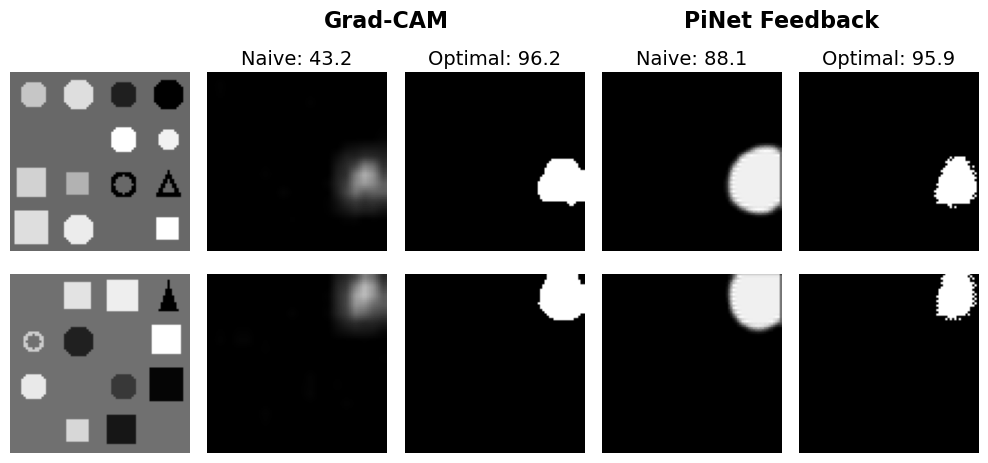

In [43]:
MAPS_small = {key: MAPS[key] for key in ['cnn_gradcam', 'pinets_feedback']}

n = 2; m = 1 + 2 * len(MAPS_small)
fig, axs = plt.subplots(n, m, figsize=(m*2.5, n*2+1), dpi=100, gridspec_kw={'wspace':0.1, 'hspace':0.1})

np.random.seed(2025)
trues = np.where(y_test)[0]
indices = np.random.choice(trues, n, replace=False)

for i in range(n):
  j = 0; idx = indices[i]
  axs[i, 0].imshow(X_test[idx].squeeze(), cmap='gray')
  for name, res in MAPS_small.items():
    ax = axs[i, j+1]
    ax.imshow(res['naive']['pi'][idx], cmap='gray', vmin=0, vmax=1)
    ax.annotate(text=make_legend_label(name), xy=(1, 1.25), xycoords='axes fraction', fontsize=16, fontweight='bold', ha='center') if not i else None
    ax.set_title(f"Naive: {res['naive']['score']*100:.1f}", fontsize=14) if not i else None
    ax = axs[i, j+2]
    ax.imshow(res['optimal']['pi'][idx], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Optimal: {res['optimal']['score']*100:.1f}", fontsize=14) if not i else None
    j += 2

[ax.axis('off') for ax in axs.flat];

if SAVE:
  plt.savefig('toyshapes/images/toyshapes_detection.png', dpi=150, bbox_inches='tight')
plt.show()

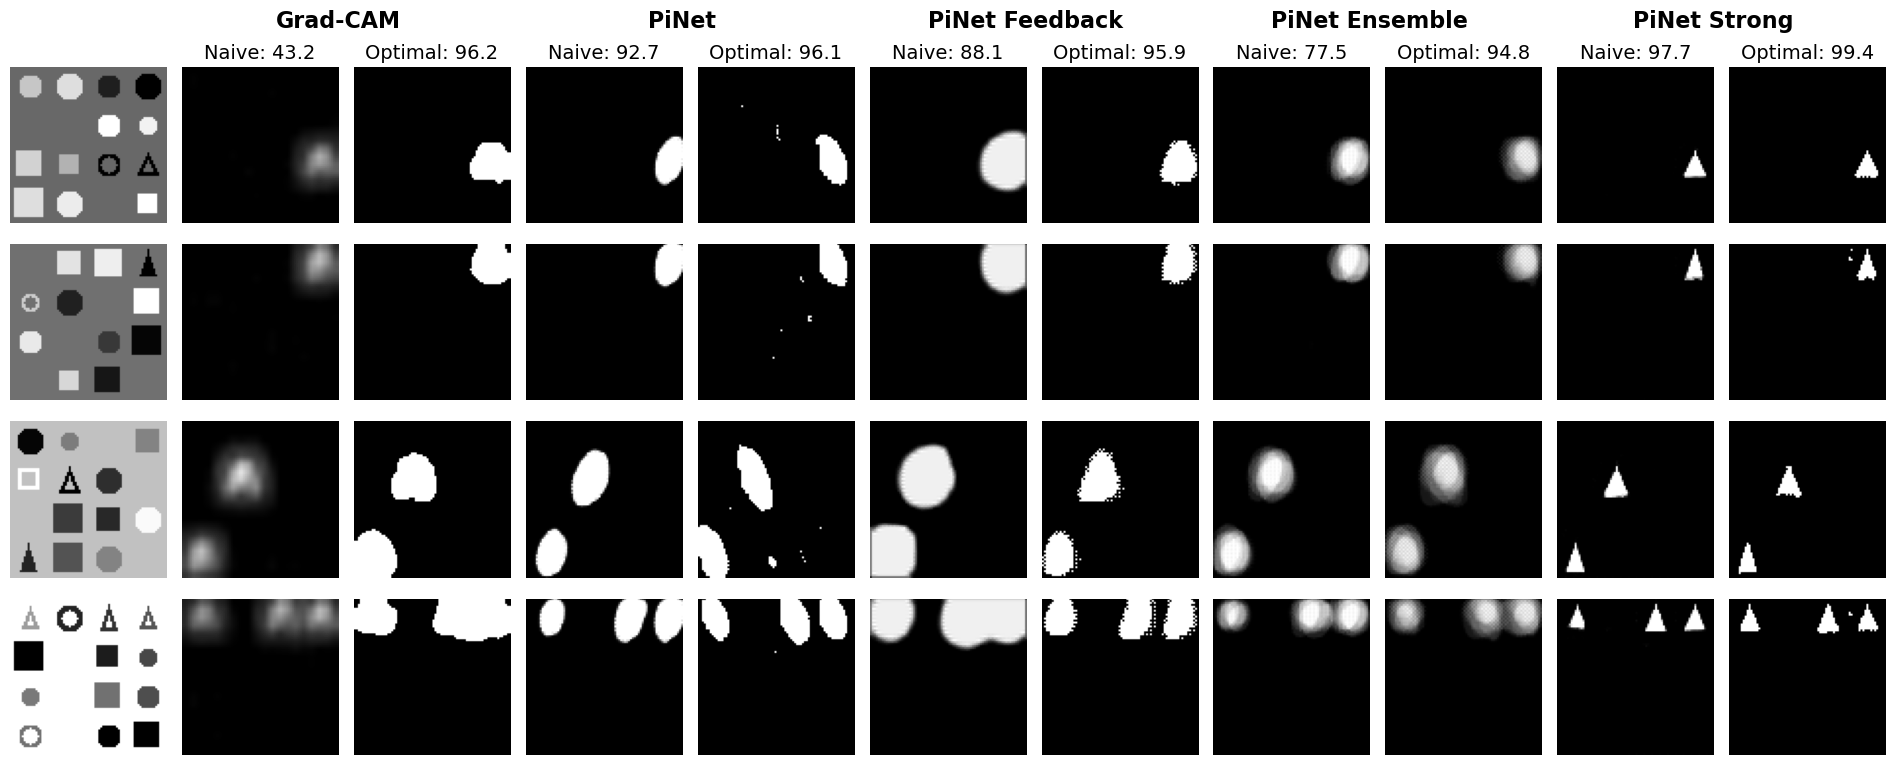

In [44]:
n = 4; m = 1+len(MAPS)*2
fig, axs = plt.subplots(n, m, figsize=(m*2.2, n*2+1), dpi=100, gridspec_kw={'wspace':0.1, 'hspace':0.1})

np.random.seed(2025)
trues = np.where(y_test)[0]
indices = np.random.choice(trues, n, replace=False)

for i in range(n):
  j = 0; idx = indices[i]
  axs[i, 0].imshow(X_test[idx].squeeze(), cmap='gray')
  for name, res in MAPS.items():
    ax = axs[i, j+1]
    ax.imshow(res['naive']['pi'][idx], cmap='gray', vmin=0, vmax=1)
    ax.annotate(text=make_legend_label(name), xy=(1, 1.25), xycoords='axes fraction', fontsize=16, fontweight='bold', ha='center') if not i else None
    ax.set_title(f"Naive: {res['naive']['score']*100:.1f}", fontsize=14) if not i else None
    ax = axs[i, j+2]
    ax.imshow(res['optimal']['pi'][idx], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Optimal: {res['optimal']['score']*100:.1f}", fontsize=14) if not i else None
    j += 2

[ax.axis('off') for ax in axs.flat];

if SAVE:
  plt.savefig('toyshapes/images/toyshapes_detection_large.png', dpi=150, bbox_inches='tight')
plt.show()